In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch import optim

In [2]:
dataset = CIFAR10('/kaggle/working', download=True, transform=T.ToTensor())

Files already downloaded and verified


In [3]:
means = (dataset.data/255).mean(axis=(0, 1, 2))
stds = (dataset.data/255).std(axis=(0, 1, 2))

In [4]:
train_transforms = T.Compose(
[
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])

valid_transforms = T.Compose(
[
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])

In [5]:
train_dataset = CIFAR10('/kaggle/working', train=True, transform=train_transforms)
valid_dataset = CIFAR10('/kaggle/working', train=False, transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)

In [6]:
class CNN_with_skip_conn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.block3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block5 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),
        )

        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.block8 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.block1(x)

        x = self.block2(x) + x

        x = self.block3(x)

        x = self.block4(x) + x

        x = self.block5(x)

        x = self.block6(x) + x

        x = self.block7(x) + x

        x = self.block8(x)

        return x

In [7]:
def train(model: nn.Module) -> tuple[float, float]:
    model.train()
    
    train_loss = []
    total = 0
    correct = 0
    
    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y==y_pred).sum().item()
        
    return np.mean(train_loss), correct/total  

In [8]:
@torch.inference_mode()
def evaluation(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()
    
    valid_loss = []
    total = 0
    correct = 0
    
    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        
        output = model(x)
        loss = loss_fn(output, y)
        valid_loss.append(loss.item())
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y==y_pred).sum().item()
        
    return np.mean(valid_loss), correct/total    

In [9]:
def plot_stats(train_loss: list[float], valid_loss: list[float],
               train_acc: list[float], valid_acc: list[float], title: str):
    plt.figure(figsize=(16, 8))
    plt.title(title + ' loss')
    plt.plot(train_loss, label='Train')
    plt.plot(valid_loss, label='Valid')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.title(title + ' accuracy')
    plt.plot(train_acc, label='Train')
    plt.plot(valid_acc, label='Valid')
    plt.legend()
    plt.grid()
    plt.show()
    

In [10]:
def whole_train_valid_cycle(model: nn.Module, num_epochs: int, title: str):
    train_hist_loss, valid_hist_loss = [], []
    train_hist_acc, valid_hist_acc = [], []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model)
        valid_loss, valid_acc = evaluation(model, valid_loader)
        
        train_hist_loss.append(train_loss)
        valid_hist_loss.append(valid_loss)
        train_hist_acc.append(train_acc)
        valid_hist_acc.append(valid_acc)
        
        clear_output()
        
        plot_stats(train_hist_loss, valid_hist_loss, 
                  train_hist_acc, valid_hist_acc, title)
        
        if epoch==(num_epochs-1):
            print(valid_hist_acc[-1])

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()

In [12]:
model = CNN_with_skip_conn()
model = model.to(device)
optimizer = optim.Adam(model.parameters())

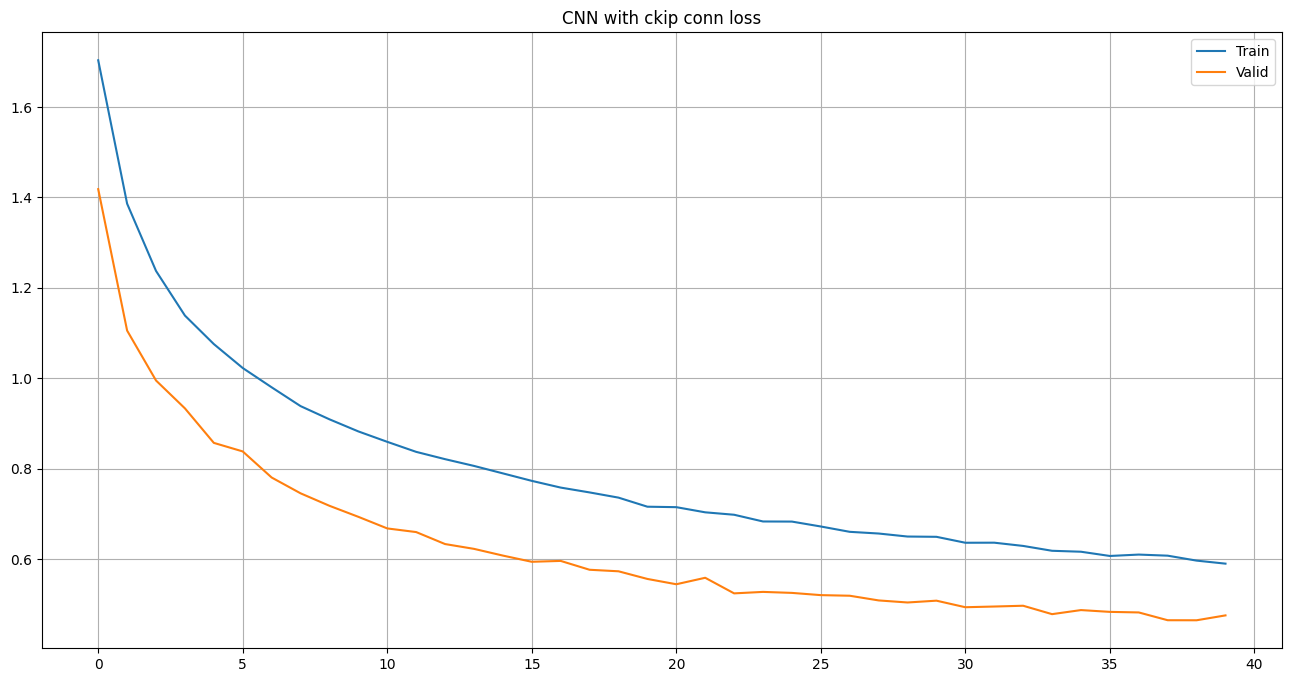

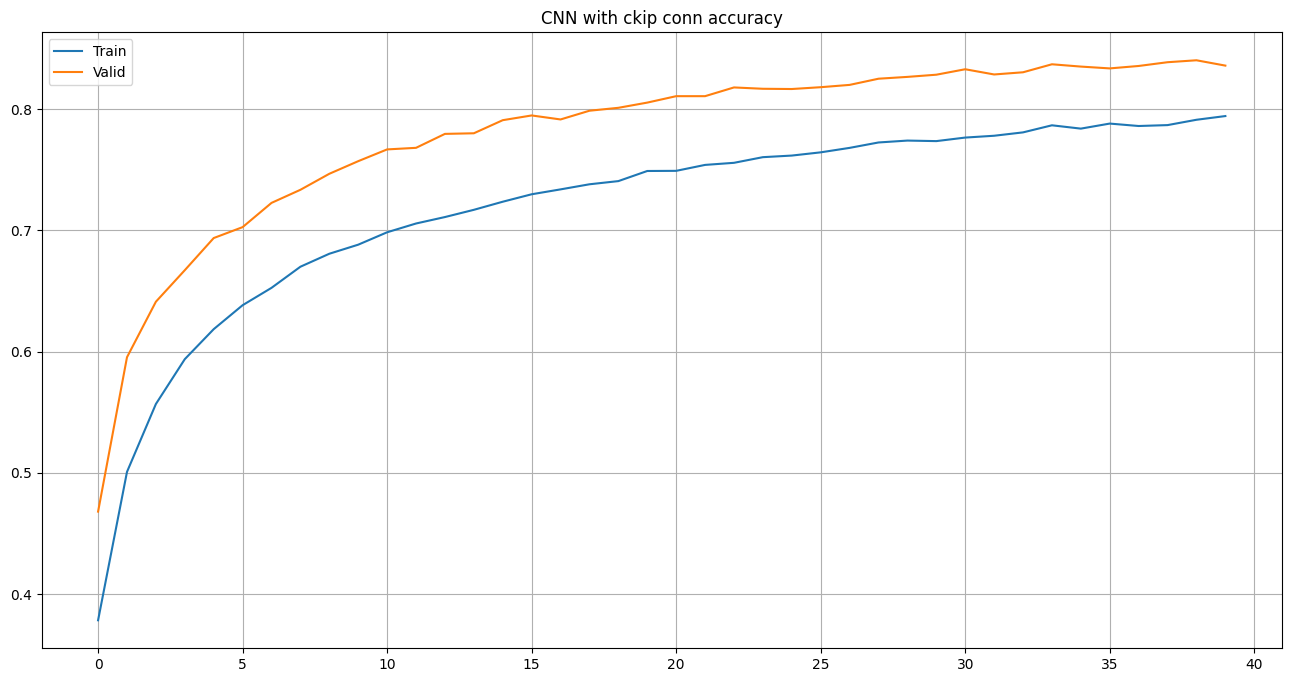

0.8359


In [13]:
whole_train_valid_cycle(model, 40, 'CNN with ckip conn')